# Feature Engineering Notebook

## Objectives

*   Engineer features for Classification, Regression and Cluster models


## Inputs

* inputs/datasets/cleaned/TrainSet.csv
* inputs/datasets/cleaned/TestSet.csv

## Outputs

* generate a list with variables to engineer

## Conclusions



* Feature Engineering Transformers
  * Ordinal categorical encoding: `['gender', 'Partner', Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']`
  * Smart Correlation Selection: `['OnlineSecurity', 'DeviceProtection', 'TechSupport']`
  


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/churnometer/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/churnometer'

---

# Load Cleaned Data

Train Set

In [4]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Female,0,Yes,No,72,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check,85.10,0
1,Female,1,No,No,14,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,46.35,0
2,Female,0,Yes,Yes,71,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),24.70,0


Test Set

In [5]:
test_set_path = 'outputs/datasets/cleaned/TestSetCleaned.csv'
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Female,0,No,No,19,Yes,No,DSL,No,Yes,No,No,Yes,No,One year,No,Electronic check,58.20,0
1,Male,0,No,No,60,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Credit card (automatic),116.60,0
2,Female,0,No,No,13,Yes,No,DSL,Yes,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,71.95,0


# Data Exploration

In feature engineering, you are interested to evaluate which potential transformation you could do in your variables
* Take your notes in your separate spreadsheet

In [6]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Correlation and PPS Analysis

* We don’t expect major changes compared to the data cleaning notebook since the only data difference is the removal of “customerID” and “TotalCharges”, so correlation levels and PPS will essentially be the same.

# Feature Engineering

## Custom function

We studied this custom function in the feature-engine lesson. That will help you with the feature engineering process.
* Do not worry if you need help understanding the full code at first, as it is expected you will take some time to absorb the use case.
* At this moment, what matters is to understand the function objective and how you can use it.

In [17]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


## Feature Engineering Spreadsheet Summary

* Consider the notes taken in your spreadsheet summary. List the transformers you will use
    * Categorical Encoding
    * Numerical Transformation
    * Smart Correlation Selection

## Dealing with Feature Engineering

### Categorical Encoding - Ordinal: replaces categories with ordinal numbers 

* Step 1: Select variable(s)

In [18]:
variables_engineering= ['gender', 'Partner', 'Dependents',
                        'PhoneService', 'MultipleLines', 'InternetService',
                        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                        'TechSupport', 'StreamingTV', 'StreamingMovies',
                        'Contract', 'PaperlessBilling', 'PaymentMethod']

variables_engineering

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

* Step 2: Create a separate DataFrame, with your variable(s)

In [19]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,Female,Yes,No,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check
1,Female,No,No,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,Female,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)


* Step 3: Create engineered variables(s) by applying the transformation(s), assess engineered variables distribution and select the most suitable method for each variable.

* Variable Analyzed: gender
* Applied transformation: ['gender_ordinal_encoder'] 



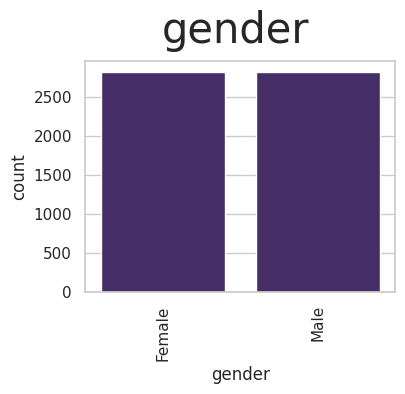

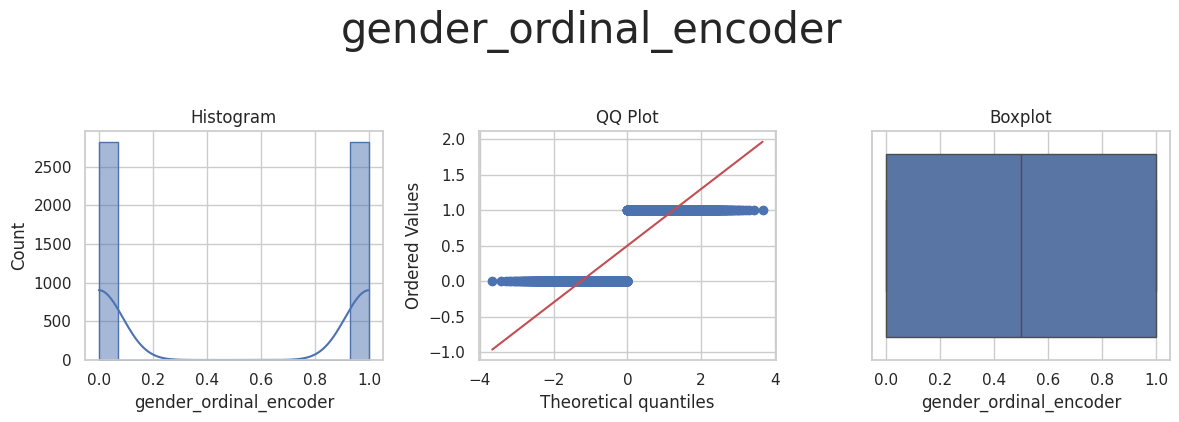



* Variable Analyzed: Partner
* Applied transformation: ['Partner_ordinal_encoder'] 



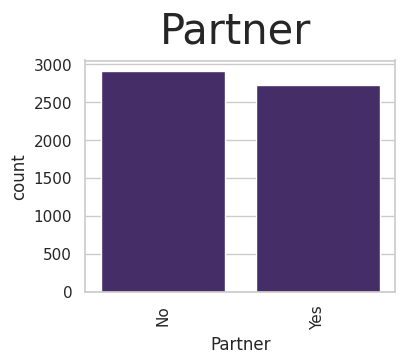

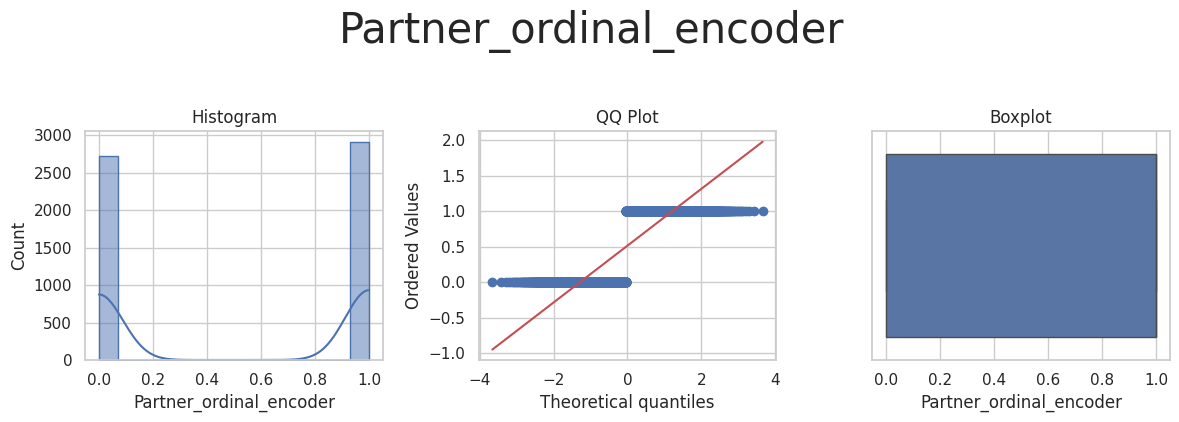



* Variable Analyzed: Dependents
* Applied transformation: ['Dependents_ordinal_encoder'] 



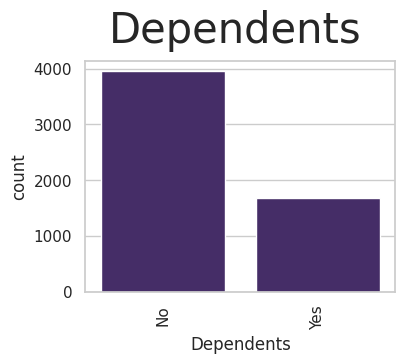

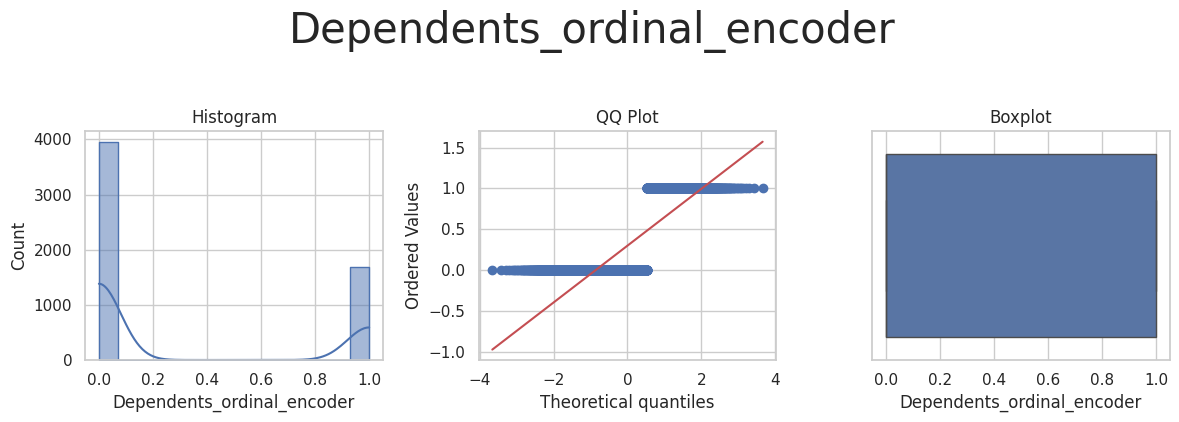



* Variable Analyzed: PhoneService
* Applied transformation: ['PhoneService_ordinal_encoder'] 



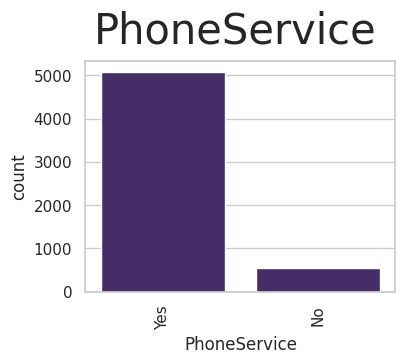

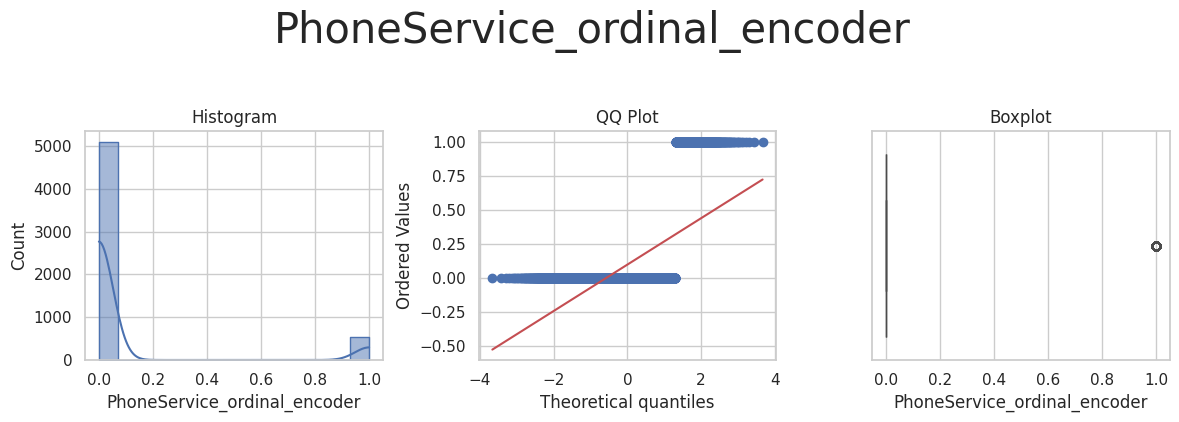



* Variable Analyzed: MultipleLines
* Applied transformation: ['MultipleLines_ordinal_encoder'] 



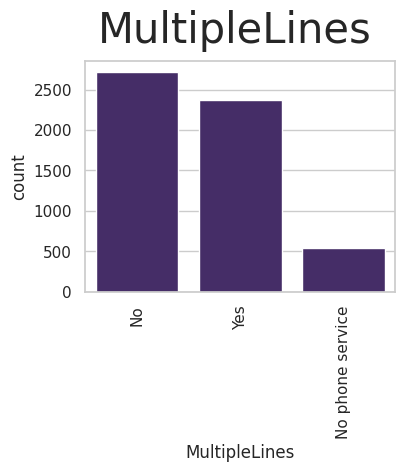

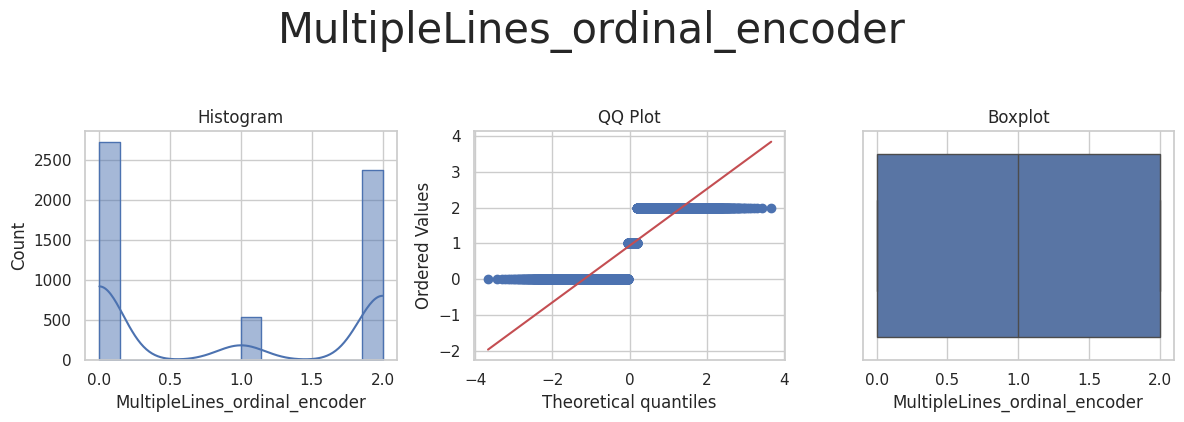



* Variable Analyzed: InternetService
* Applied transformation: ['InternetService_ordinal_encoder'] 



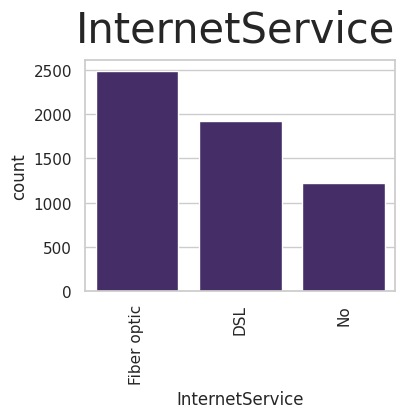

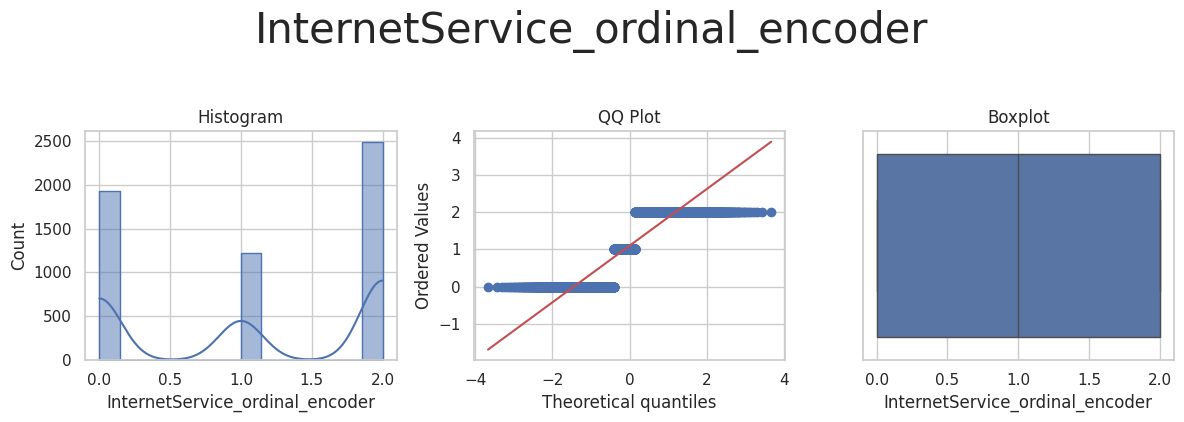



* Variable Analyzed: OnlineSecurity
* Applied transformation: ['OnlineSecurity_ordinal_encoder'] 



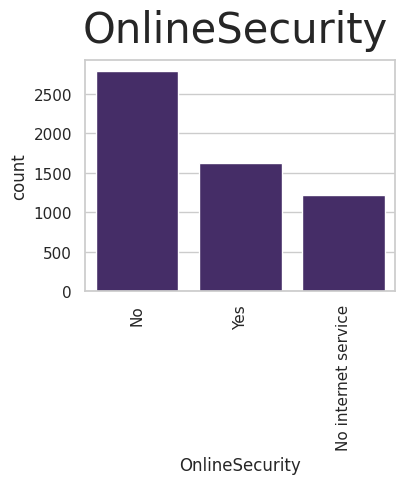

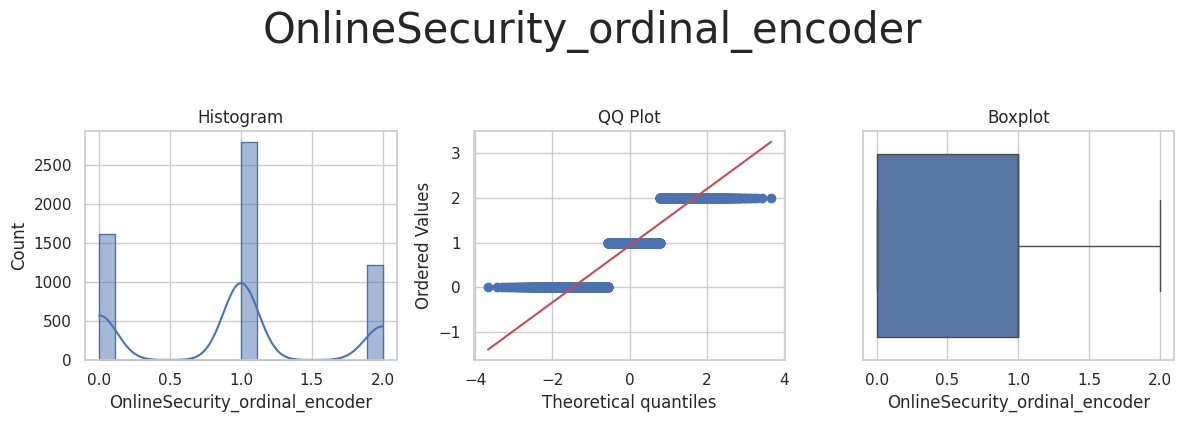



* Variable Analyzed: OnlineBackup
* Applied transformation: ['OnlineBackup_ordinal_encoder'] 



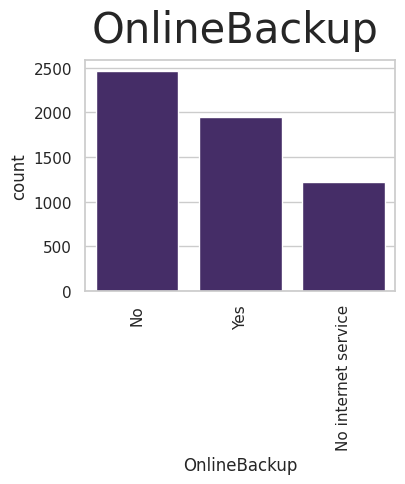

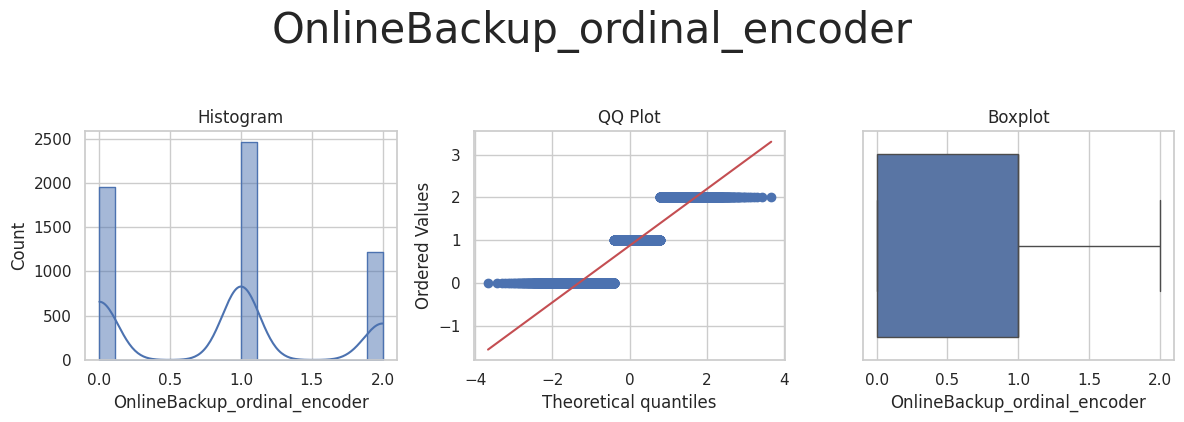



* Variable Analyzed: DeviceProtection
* Applied transformation: ['DeviceProtection_ordinal_encoder'] 



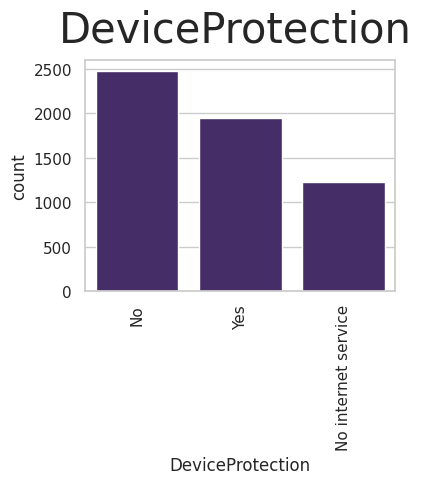

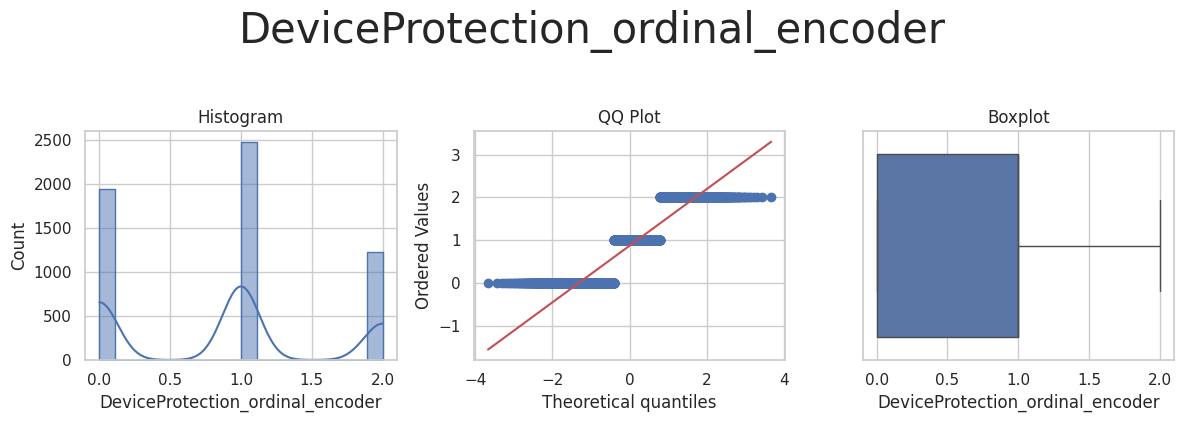



* Variable Analyzed: TechSupport
* Applied transformation: ['TechSupport_ordinal_encoder'] 



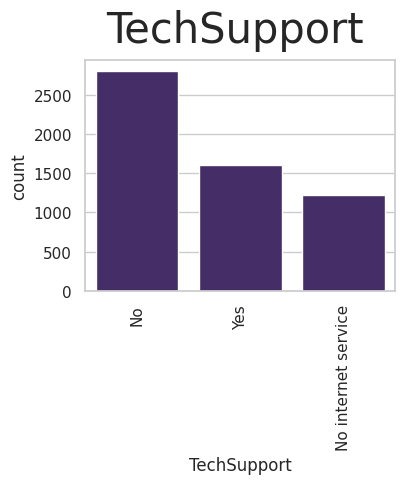

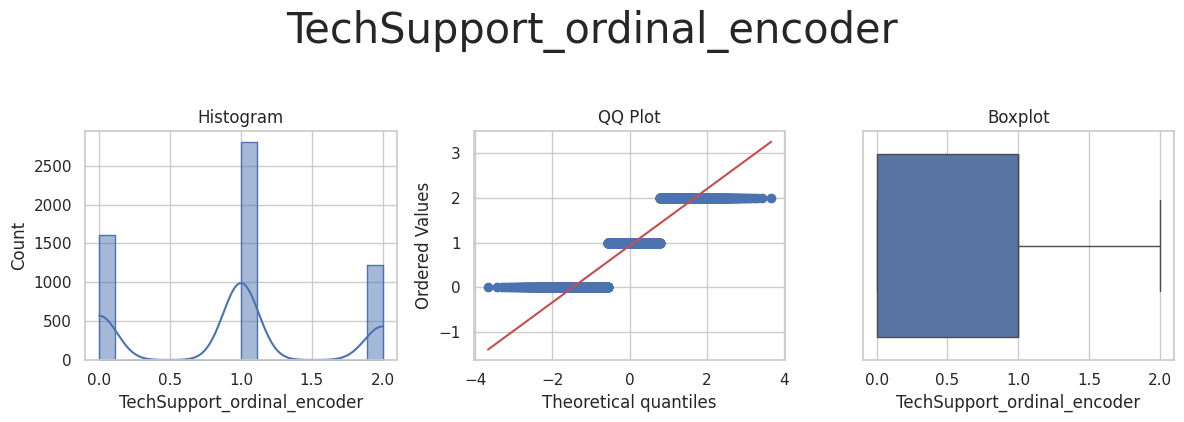



* Variable Analyzed: StreamingTV
* Applied transformation: ['StreamingTV_ordinal_encoder'] 



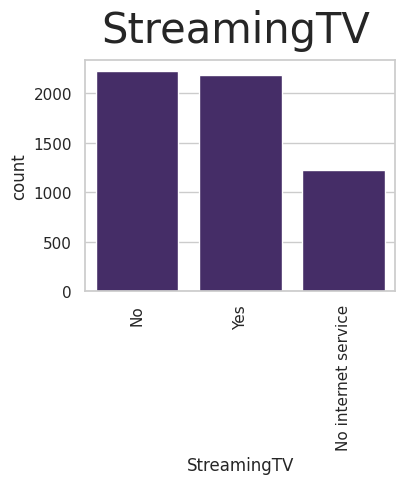

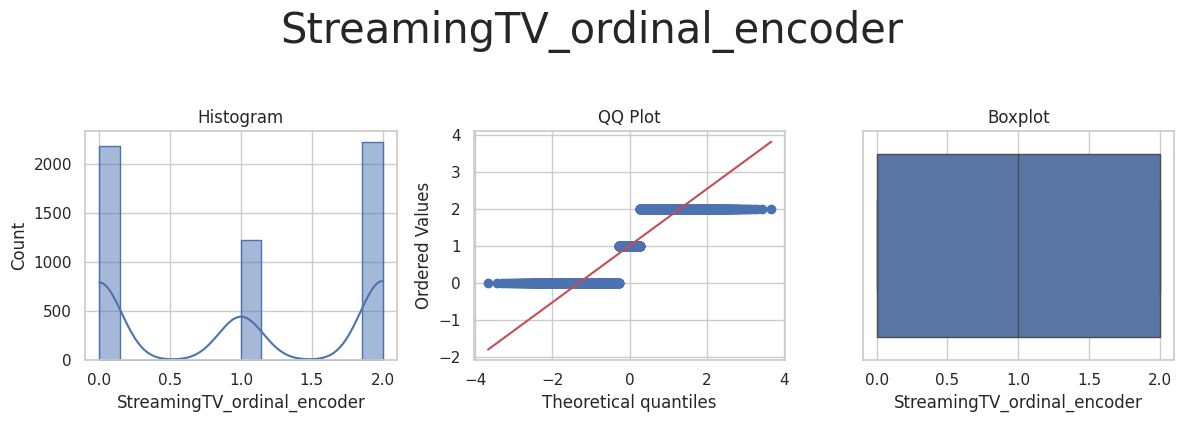



* Variable Analyzed: StreamingMovies
* Applied transformation: ['StreamingMovies_ordinal_encoder'] 



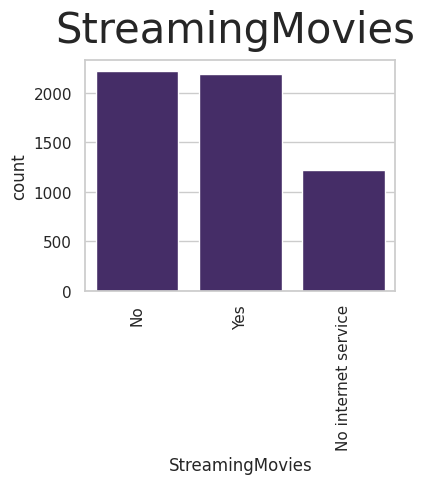

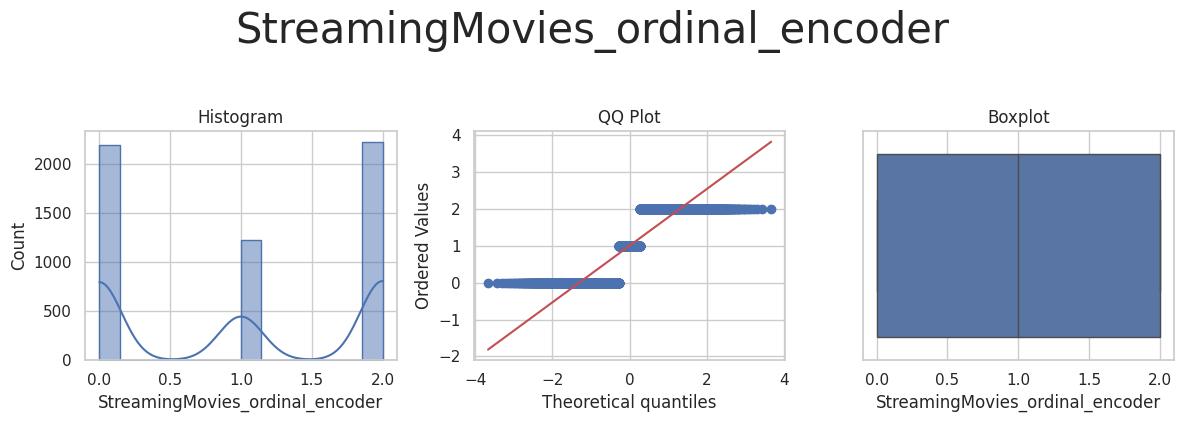



* Variable Analyzed: Contract
* Applied transformation: ['Contract_ordinal_encoder'] 



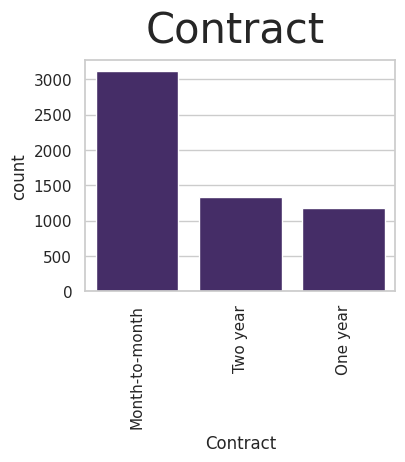

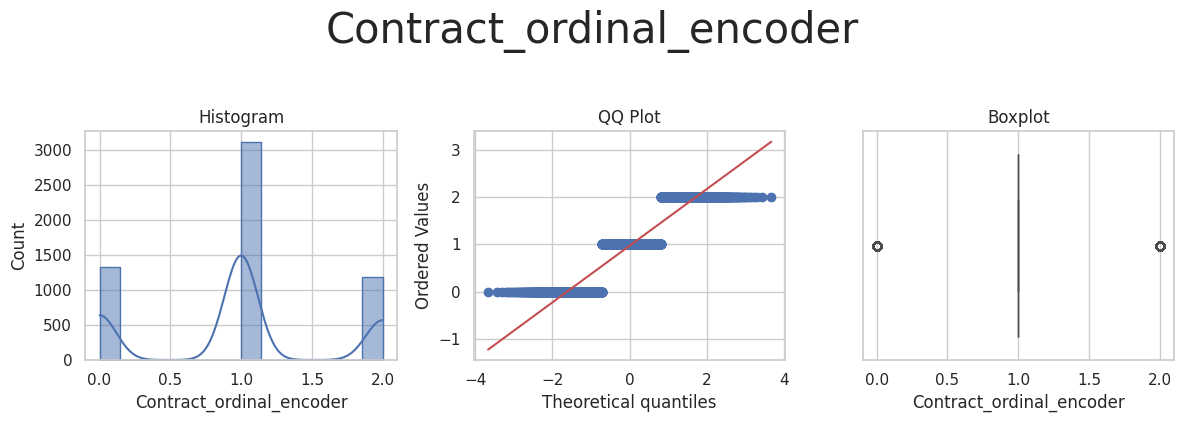



* Variable Analyzed: PaperlessBilling
* Applied transformation: ['PaperlessBilling_ordinal_encoder'] 



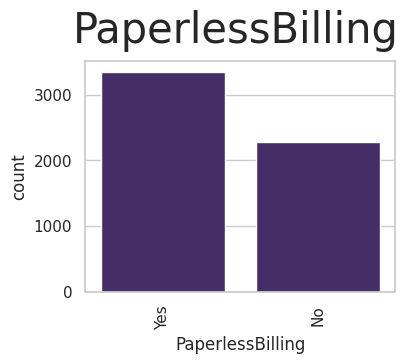

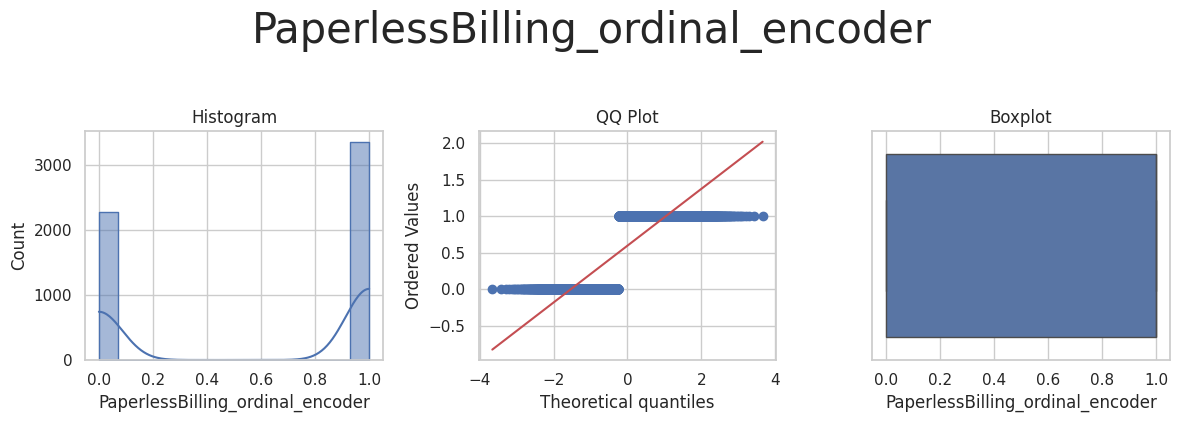



* Variable Analyzed: PaymentMethod
* Applied transformation: ['PaymentMethod_ordinal_encoder'] 



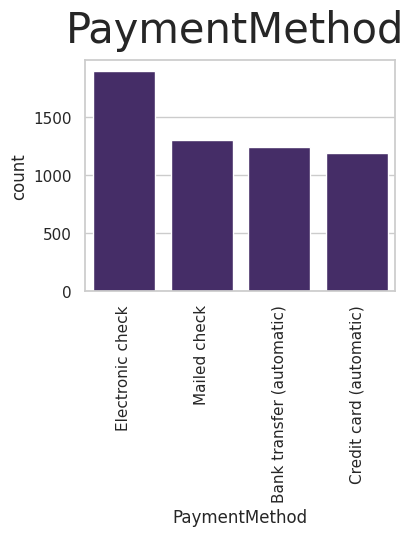

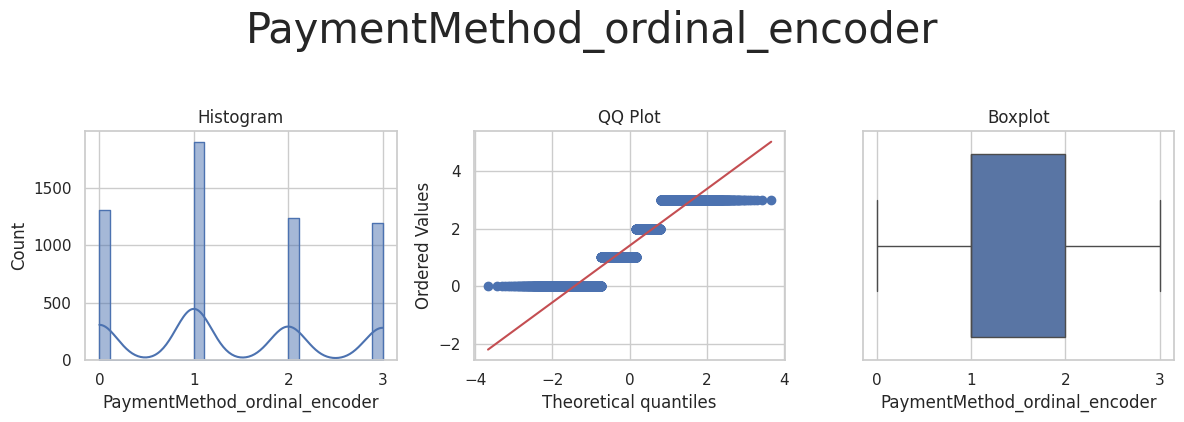

In [20]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')

* For each variable, write your conclusion on how the transformation(s) look(s) to be effective.
  * For all variables, the transformation is effective, since it converted categories to numbers.



* Step 4 - Apply the selected transformation to the Train and Test set

In [21]:
# the steps are: 
# 1 - create a transformer
# 2 - fit_transform into TrainSet
# 3 - transform into TestSet 
encoder = OrdinalEncoder(encoding_method='arbitrary', variables = variables_engineering)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)

print("* Categorical encoding - ordinal transformation done!")

* Categorical encoding - ordinal transformation done!


### Numerical Transformation

* Step 1: Select variable(s)

In [ ]:
variables_engineering = ['tenure', 'MonthlyCharges']
variables_engineering

* Step 2: Create a separate DataFrame, with your variable(s)

In [ ]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

* Step 3: Create engineered variables(s) by applying the transformation(s), assess engineered variables distribution and select the most suitable method

In [ ]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

* For each variable, write your conclusion on how the transformation(s) look(s) to be effective
  * For all variables - it didn't improve the boxplot distribution or qq plot


* Step 4 - Apply the selected transformation to the Train and Test set

In [ ]:
# we are not applying any numerical transformation to the data

### SmartCorrelatedSelection Variables

* Step 1: Select variable(s)

In [ ]:
# for this transformer, you don't need to select variables, since you need all variables for this transformer

* Step 2: Create a separate DataFrame, with your variable(s)

In [ ]:
df_engineering = TrainSet.copy()
df_engineering.head(3)

* Step 3: Create engineered variables(s) applying the transformation(s)

In [ ]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_

In [ ]:
corr_sel.features_to_drop_

---

# So what is the conclusion? :)


The list below shows the transformations needed for feature engineering.
  * You will add these steps to the ML Pipeline


Feature Engineering Transformers
  * Ordinal categorical encoding: `['gender', 'Partner', Dependents', 'PhoneService','MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']`
  * Smart Correlation Selection: `['OnlineSecurity', 'DeviceProtection', 'TechSupport']`
  

* Well done! Clear the outputs, and move on to the following notebook.